# Exploration of Crime and Geographic Location in Atlanta.




In [7]:
# Import Libraries Needed to Solve Question 1
!pip install altair
!pip install vega-datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
from vega_datasets import data
import jsonschema
import requests
from bs4 import BeautifulSoup
import pprint

In [8]:
# For Data Manipulation and Visulaization I put Data into a pandas DataFrame
atlcrimedf = pd.read_csv('newatlcrime.csv')

# Prints of the type of this dataset
print(type(atlcrimedf))

<class 'pandas.core.frame.DataFrame'>


In [9]:
# Print out the first 5 rows to examine what columns this dataframe contains
atlcrimedf.head()

,offense_id,rpt_date,occur_date,occur_day,occur_day_num,occur_time,poss_date,poss_time,beat,zone,location,ibr_code,UC2_Literal,neighborhood,npu,lat,long
0,21140096,5/20/2021,5/19/2021,Wednesday,4.0,15:20,5/19/2021,15:25,103,1,"1720 MARIETTA BLVD NW\nATLANTA, GA 30318\nUNIT...",23F,LARCENY-FROM VEHICLE,Hills Park,D,33.801693,-84.436453
1,21282015,8/6/2021,8/6/2021,Friday,6.0,22:23,8/6/2021,22:24,508,5,"300 PEACHTREE ST NE\nATLANTA, GA 30308\nUNITED...",23F,LARCENY-FROM VEHICLE,Downtown,M,33.762549,-84.387874
2,21791668,6/28/2021,6/27/2021,Sunday,1.0,21:17,6/28/2021,20:00,102,1,"870 MAYSON TURNER RD NW\nATLANTA, GA 30314\nUN...",23H,LARCENY-NON VEHICLE,Vine City,L,33.755768,-84.416631
3,200041082,1/5/2021,1/4/2021,Monday,2.0,16:00,1/4/2021,17:00,605,6,"275 MEMORIAL DR SE\nATLANTA, GEORGIA 30312\nUN...",23C,LARCENY-NON VEHICLE,Grant Park,W,33.746503,-84.378535
4,202611428,9/18/2021,9/18/2021,Saturday,7.0,18:04,9/18/2021,18:15,112,1,"2750 DONALD LEE HOLLOWELL PKWY NW\nATLANTA, GA...",23C,LARCENY-NON VEHICLE,Collier Heights,I,33.777383,-84.477433


In [10]:
atlGeoJson = "https://raw.githubusercontent.com/blackmad/neighborhoods/master/atlanta.geojson"

states = alt.topo_feature(atlGeoJson, feature="county")

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white',
).properties(
    width=960,
    height=500,
    
    
)


atlcrimedfSample = atlcrimedf.sample(5000)
points = alt.Chart(atlcrimedfSample).mark_circle(
    opacity = .1
).encode(
    longitude = 'long:Q',
    latitude = 'lat:Q',
    size=alt.value(60),
    color = 'UC2_Literal:N',
    tooltip = ['neighborhood:N']
)


atlmap = background +points
atlmap

alt.LayerChart(...)

In [11]:
#dictionary will be storing neighborhood name and number of crimes
dictionary = {}

#for every row in our 500 sample
for row in atlcrimedf["offense_id"].sample(500):
    
    #customized url from Atlanta PD
    url = "https://services3.arcgis.com/Et5Qfajgiyosiw4d/arcgis/rest/services/CrimeDataExport_2_view/FeatureServer/1/query"
    report_num = str(row)
    params = {
        "where": "report_number = "+report_num,
        "outFields": "was_firearm_invloved,report_number,victim_count,report_Date,NhoodName,location_type",
        "outSR": "4326",
        "f": "json"
    }

    
    response = requests.get(url, params=params)
    
    data = response.json()
    
    if response.status_code == 200 and data['features'] != []:
        
        if data['features'][0]['attributes']['NhoodName'] in dictionary:
            #adds one by associated key
                dictionary[data['features'][0]['attributes']['NhoodName']] += 1
            # genre !in dictionary add it to the dictionary and set value to 1
        elif data['features'][0]['attributes']['NhoodName'] not in dictionary:
                dictionary[data['features'][0]['attributes']['NhoodName']] = 1
                
        
        
if None in dictionary:
    del dictionary[None]
            
    

ConnectionError: HTTPSConnectionPool(host='services3.arcgis.com', port=443): Max retries exceeded with url: /Et5Qfajgiyosiw4d/arcgis/rest/services/CrimeDataExport_2_view/FeatureServer/1/query?where=report_number+%3D+203661785&outFields=was_firearm_invloved%2Creport_number%2Cvictim_count%2Creport_Date%2CNhoodName%2Clocation_type&outSR=4326&f=json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe9b3c2e5e0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
df = pd.DataFrame.from_dict(dictionary, orient="index", columns=["Number of Crimes"])
df = df.sort_values(by="Number of Crimes", ascending=False).head(10)

df.plot(kind="bar", color="green", legend=None, width=.75, figsize=(12, 7))

plt.xlabel("Neighborhoods", fontsize=15)
plt.ylabel("Number of Crimes", fontsize=15)
plt.title("Most Dangerous Neighborhoods", fontsize=30)


plt.show()

In [ ]:
gunviolence = {}

for row in atlcrimedf["offense_id"].sample(500):
    url = "https://services3.arcgis.com/Et5Qfajgiyosiw4d/arcgis/rest/services/CrimeDataExport_2_view/FeatureServer/1/query"
    report_num = str(row)
    params = {
        "where": "report_number = "+report_num,
        "outFields": "was_firearm_invloved,report_number,victim_count,report_Date,NhoodName,location_type",
        "outSR": "4326",
        "f": "json"
    }


    response = requests.get(url, params=params)
    
    data = response.json()
    
    if response.status_code == 200 and data['features'] != []:
        if data['features'][0]['attributes']['location_type'] in gunviolence and data['features'][0]['attributes']['was_firearm_invloved'] == 'Y':
                gunviolence[data['features'][0]['attributes']['location_type']] += 1
        elif data['features'][0]['attributes']['location_type'] not in gunviolence and data['features'][0]['attributes']['was_firearm_invloved'] == 'Y':
                gunviolence[data['features'][0]['attributes']['location_type']] = 1
        print(gunviolence)
    

In [ ]:
placesandgunviolence = pd.DataFrame.from_dict(gunviolence, orient="index", columns=["Number of Gun Crimes"])
placesandgunviolence = placesandgunviolence.sort_values(by="Number of Gun Crimes", ascending=True).head(10)

places = list(gunviolence.keys())
crime_counts = list(gunviolence.values())


plt.figure(figsize=(15, 8)) 
plt.bar(places, crime_counts, color='red')


plt.xlabel('Types of Places',fontsize=15)
plt.ylabel('Number of Gun Crimes',fontsize=15)
plt.title('Gun Related Crimes', fontsize=30)


plt.xticks(rotation=90)


plt.show()




In [ ]:
#changes the format of the time column from 14:39 to just 14
atlcrimedf['occur_time'] = atlcrimedf['occur_time'].str.split(':').str[0]
atlcrimedf.head()

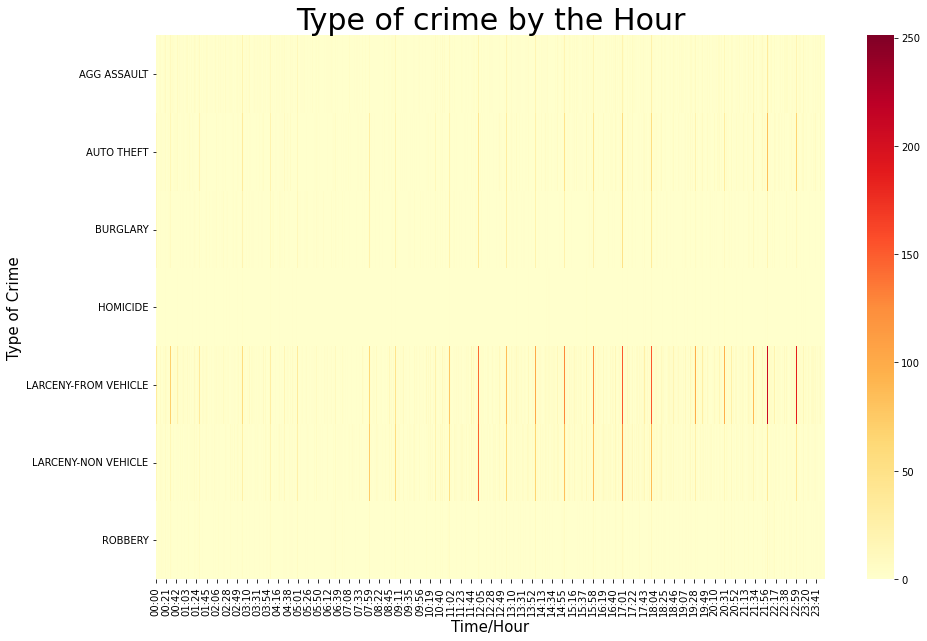

In [12]:

heatmap_data = atlcrimedf.pivot_table(index='UC2_Literal', columns='occur_time', aggfunc='size', fill_value=0)


plt.figure(figsize=(15, 10))  
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar=True)


plt.xlabel('Time/Hour',fontsize=15)
plt.ylabel('Type of Crime',fontsize=15)
plt.title('Type of crime by the Hour',fontsize=30)


plt.show()